# Bias, Variance and Model selection

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from collections import defaultdict


import matplotlib.pyplot as plt

%matplotlib inline

# Setup Seaborn
sns.set(rc={"figure.figsize": (10, 8), "font.size": 11})
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.0, rc={"lines.linewidth": 2.5})

### Useful functions

In [2]:
def fTrue(x):
    """ True function """
    return 2.0 + 5.0 * x + 1.0 * x**2 - 0.08 * x**3

def fPred(X, beta):
    """ Model prediction """
    return X @ beta

def predBeta(X, y):
    """ beta hat """
    return np.linalg.inv(X.T @ X) @ (X.T @ y)

def hatMatrix(X):
    """ hat matrix """
    return X @ np.linalg.inv((X.T @ X)) @ X.T

def mse(y, yHat):
    return np.mean((y-yHat)**2)

def designMatrix(x, p):
    """ Generate design matrix with polynomial powers """
    n = len(x)
    
    # Bias term
    arrs = []
    arrs.append(np.ones(n))
    
    # Polynomial terms
    for q in range(1,p+1):
        arrs.append(np.power(x,q))

    X = np.stack(arrs, axis=1)
    
    return X

In [3]:
# Parameters
np.random.seed(2)
n = 500   # Number of observations
pmax = 7  # Max polynomial power + 1
s = 5.0   # Irreducable error

# Create observations
x = np.random.normal(loc = 1.0, scale = 2.0, size = n)
x = np.sort(x)

# Model and target variable
e = np.random.normal(loc=0.0, scale=s, size=n)
y = fTrue(x) + e # true model + irreducable error

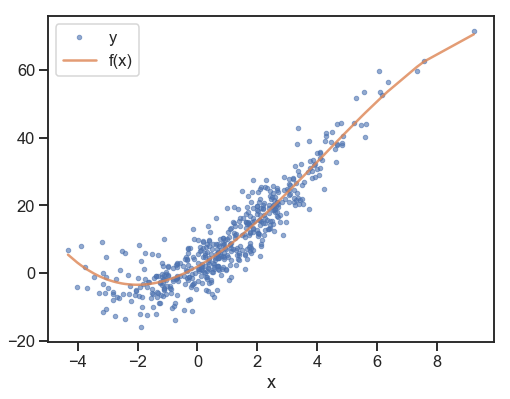

In [4]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,y, '.', alpha = 0.6, label = 'y')

plt.plot(x, fTrue(x),'-', alpha=0.8, label = 'f(x)')
plt.xlabel('x')
plt.ylabel('')
plt.legend()
#plt.savefig("numeric_example.pdf")
plt.show()

In [5]:
# Design matrix
X = designMatrix(x, pmax)

# Split data into training and test
n_tr = int(n * 0.7)
idx = np.random.permutation(n)
idx_tr, idx_ts = idx[:n_tr], idx[n_tr:]
X_tr, X_ts = X[idx_tr], X[idx_ts]
y_tr, y_ts = y[idx_tr], y[idx_ts]

In [6]:
# Loop over the number of features
cache = defaultdict(list)
for q in range(pmax):
    X0_tr, X0_ts = X_tr[:,:q+1], X_ts[:,:q+1]
    
    # fit
    betaHat = predBeta(X0_tr, y_tr)
    
    # predicted y
    yHat_tr = fPred(X0_tr, betaHat)
    yHat_ts = fPred(X0_ts, betaHat)
    
    # mse
    mse_tr = mse(y_tr, yHat_tr)
    mse_ts = mse(y_ts, yHat_ts)
    
    # save
    cache['p'].append(q)
    cache['mse_tr'].append(mse_tr)
    cache['mse_ts'].append(mse_ts)

df_results = pd.DataFrame(cache)

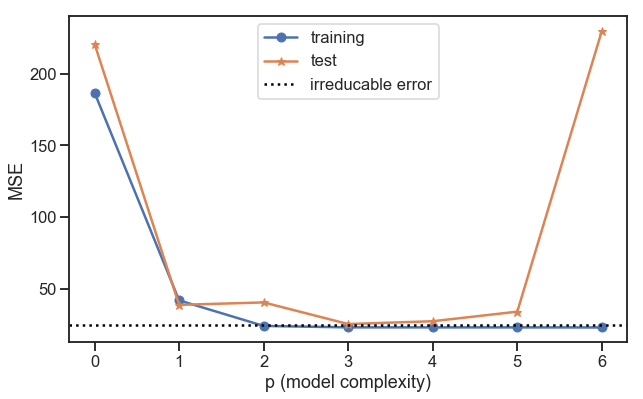

In [7]:
fig = plt.figure(figsize=(10,6))
temp = df_results[df_results.p > 0]
plt.plot(df_results['p'], df_results['mse_tr'], 'o-', label = 'training')
plt.plot(df_results['p'], df_results['mse_ts'], '*-', label = 'test')
plt.axhline(s*s, linestyle = ':', color='black', label = 'irreducable error')
plt.legend()
plt.xlabel('p (model complexity)')
plt.ylabel('MSE')
plt.show()
#plt.savefig("test_error.pdf")


In [8]:
nDimBest_ts = np.argmin(df_results['mse_ts'].values)
nDimBest_tr = np.argmin(df_results['mse_tr'].values)
print("Best dimensions :: via mse_tr = {:d}, via = {:d}".format(nDimBest_tr, nDimBest_ts))

Best dimensions :: via mse_tr = 6, via = 3


In [9]:
# Best model by test set
q = 3
X0_tr, X0_ts = X_tr[:,:q+1], X_ts[:,:q+1]
    
# fit
betaHat = predBeta(X0_tr, y_tr)


In [10]:
betaHat

array([ 1.55621127,  5.05240827,  0.97881125, -0.06491659])

### Bias and Variance Computation

In [20]:
# For each p, compute bias and variance
biases = []
variances = []

fx = fTrue(x) # true f
for p in range(pmax):
    h = hatMatrix(X[:,:p+1])
    yHat = h @ y
    
    bias_ = (np.eye(n) - h) @ fx
    s2Hat = np.sum((y-yHat)**2) / (n - p + 1) # s2Hat is an estimator of s^2
    var_ = s2Hat * np.diag(h)
    
    biases.append(bias_)
    variances.append(var_)



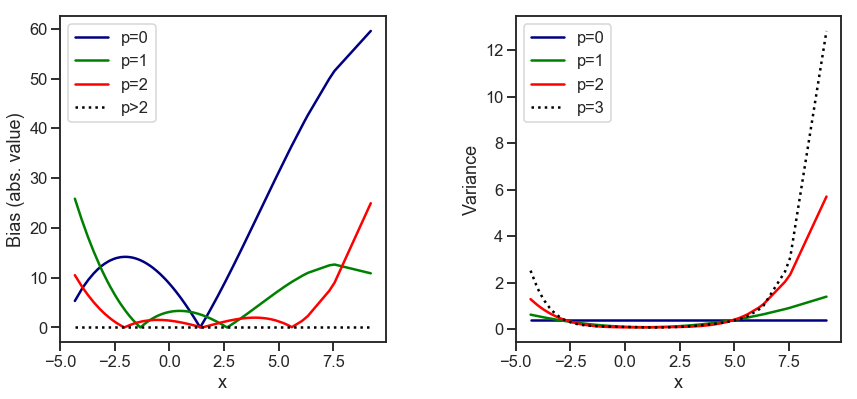

In [21]:
# Plot bias and variance
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,6))
plt.subplots_adjust(wspace=0.4)

# Plot bias
ax1.plot(x, np.abs(biases[0]), color = 'navy', label='p=0')
ax1.plot(x, np.abs(biases[1]), color = 'green', label='p=1')
ax1.plot(x, np.abs(biases[2]), color = 'red', label='p=2')
ax1.plot(x, np.abs(biases[3]), color = 'black',label='p>2', linestyle=':')
ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('Bias (abs. value)')

# Plot variance
plt.plot(x, variances[0], color = 'navy', label='p=0')
plt.plot(x, variances[1], color = 'green', label='p=1')
plt.plot(x, variances[2], color = 'red', label='p=2')
plt.plot(x, variances[3], color = 'black', label='p=3', linestyle=':')
ax2.legend()
ax2.set_xlabel('x')
ax2.set_ylabel('Variance')

#plt.savefig("biasAndVar.pdf")
plt.show()

In [15]:
# Stack bias and variance 
varByp = np.stack(variances, axis=1)
biasByp = np.abs(np.stack(biases, axis=1))

In [16]:
# Mean across data
varByp.mean(axis=0)

array([0.3935175 , 0.1648251 , 0.16245712, 0.19042243, 0.23849865,
       0.28646352, 0.33483269])

In [17]:
# Mean across data
biasByp.mean(axis=0)

array([1.02463593e+01, 3.04652584e+00, 1.25551117e+00, 1.73885212e-14,
       5.07421341e-13, 2.19323401e-12, 5.21135260e-12])

In [18]:
# Example
p_ = 3
betaHat = predBeta(X[:,:p_+1], y)
fHat = fPred(X[:,:p_+1], betaHat)

h = hatMatrix(X[:,:p_+1]) 
varHat = np.var(y) * np.diag(h) 


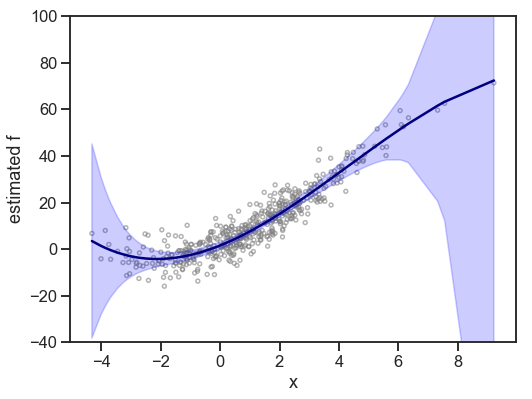

In [19]:
fig = plt.figure(figsize=(8,6))
plt.plot(x, fHat, color='navy', label = 'p=3 Fit')
plt.scatter(x, y, marker='o', s=15, facecolors='none', edgecolors='grey', alpha=0.6)
plt.fill_between(x, fHat - 2.0 * varHat, fHat + 2.0 * varHat, alpha=0.2, color='blue')
plt.ylim([-40,100])
plt.xlabel('x')
plt.ylabel('estimated f')
plt.show()